*Note: only the "binary" dataset is used in the  notebook, extension to the "multi" dataset is done after converting to a Python project.*

# Part 1: Data Loading

### Import libraries

In [479]:
import joblib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [480]:
RANDOM_SEED = 111

### Load training data

In [481]:
%%time
X_train_binary = pd.read_csv("../data/binary/X_train.csv", header=None)
y_train_binary = pd.read_csv("../data/binary/Y_train.csv", header=None)

CPU times: user 10.7 s, sys: 779 ms, total: 11.4 s
Wall time: 11.5 s


# Part 2: Data cleaning & create new input features

In [616]:
#todo

# Part 3. Data Visualisation & Analysis

In [483]:
X_train_binary.shape

(62210, 964)

--> Training data summary:
* There are 62,210 rows (images)
* There are 964 columns (feature):
    * first 900 columns = **HoG (Histogram of oriented Gradients)** extracted from the image (10×10 px cells, 9 orientations, 2×2 blocks).
    * next 16 columns drawn from a **normal distribution** (µ = 0.5, σ = 2)
    * last 48 columns correspond to 3 **colour histograms** extracted from the same image, one for each channel (RGB), with 16 bins per channel.

They are split into 3 different sets for further analysis and visualisation

In [484]:
X_train_HoG = X_train_binary.iloc[:, :900]
X_train_normal_dist = X_train_binary.iloc[:, 900:916]
X_train_colour_hists = X_train_binary.iloc[:, 916:]

### A. HoG (Histogram of oriented Gradients)

In [485]:
X_train_HoG.head(5)

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.108247,0.004364,0.006292,0.012344,0.125419,0.211368,0.308308,0.308308,0.047714,0.147246,...,0.086864,0.231606,0.010222,0.111093,0.036183,0.151264,0.166743,0.216403,0.231606,0.072554
1,0.245888,0.057265,0.054288,0.073985,0.245888,0.143398,0.113087,0.208721,0.173131,0.245888,...,0.018032,0.204783,0.059727,0.248219,0.248219,0.248219,0.121050,0.067763,0.037096,0.025164
2,0.218803,0.107196,0.056075,0.108894,0.143207,0.079305,0.068837,0.147177,0.089514,0.166596,...,0.232862,0.232918,0.048630,0.105441,0.028698,0.191464,0.218813,0.232918,0.232918,0.092948
3,0.199052,0.099943,0.109036,0.095986,0.218288,0.205510,0.218288,0.113477,0.128925,0.218288,...,0.161302,0.234259,0.134242,0.185844,0.164967,0.234259,0.064108,0.043844,0.234259,0.119083
4,0.234368,0.163826,0.135215,0.234368,0.219650,0.100049,0.056125,0.065694,0.148874,0.234368,...,0.243317,0.243317,0.047693,0.084939,0.123729,0.113036,0.243317,0.194783,0.243317,0.136803


In [486]:
X_train_HoG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Columns: 900 entries, 0 to 899
dtypes: float64(900)
memory usage: 427.2 MB


Visualise a reconstruction of the image from the HoG.

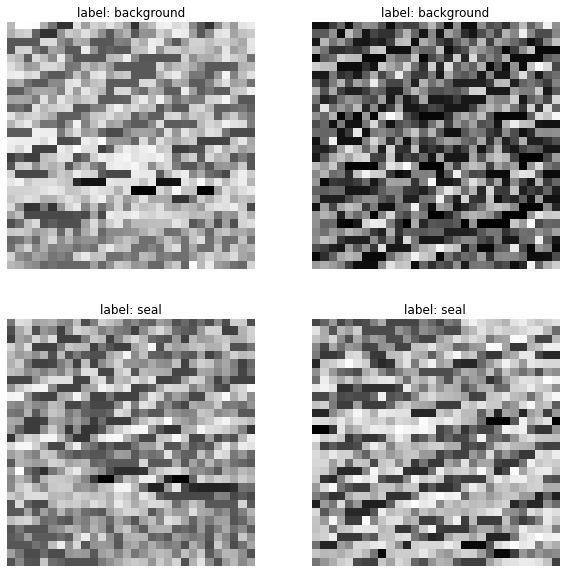

In [648]:
fig=plt.figure(figsize=(10, 10))

image_background1 = X_train_HoG.iloc[0].to_numpy().reshape(30, 30)
fig.add_subplot(221)
plt.imshow(image_background1, cmap="binary")
plt.title("label: background")
plt.axis("off")

image_background2 = X_train_HoG.iloc[1080].to_numpy().reshape(30, 30)
fig.add_subplot(222)
plt.imshow(image_background2, cmap="binary")
plt.title("label: background")
plt.axis("off")

image_seal1 = X_train_HoG.iloc[62209].to_numpy().reshape(30, 30)
fig.add_subplot(223)
plt.imshow(image_seal1, cmap="binary")
plt.title("label: seal")
plt.axis("off")

image_seal2= X_train_HoG.iloc[62100].to_numpy().reshape(30, 30)
fig.add_subplot(224)
plt.imshow(image_seal2, cmap="Blues")
plt.title("label: seal")
plt.axis("off")

plt.savefig("reconstructed_images_binary.png")
plt.show()

Observation:
* There is little difference between a background and a seal

--> Reconstructed image doesn't give any information useful for classification.    

### B. Normal distribution

In [487]:
X_train_normal_dist.head(5)

,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915
0,-1.280041,1.238382,2.661622,-2.942723,0.256651,-0.847558,-0.144272,-3.628990,-0.317223,2.649822,5.004708,-4.185132,-0.319661,-0.403782,0.837098,0.674467
1,1.734251,3.321642,-1.756527,3.417488,-1.973764,-0.026902,2.733768,1.420462,0.212293,0.360131,1.912276,6.072646,-3.138425,-1.144073,-0.793034,-2.189273
2,-1.218798,-0.706921,-0.970352,1.446063,1.069938,4.533852,2.815861,-0.491769,-0.232733,1.098961,-0.329036,2.557483,-1.199582,0.998466,-1.331319,1.782689
3,-2.192398,-1.735968,2.031139,0.725424,-0.305053,-1.314722,-1.477061,3.391574,3.039285,-0.780832,0.132886,2.852817,4.059947,-0.462990,3.677201,-4.173188
4,-0.691028,-4.928038,-2.162437,1.651693,0.314290,2.053126,6.163571,1.326052,-2.152279,3.103169,-1.078835,-0.374443,1.339320,-0.335326,0.810662,-0.089223


In [488]:
X_train_normal_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   900     62210 non-null  float64
 1   901     62210 non-null  float64
 2   902     62210 non-null  float64
 3   903     62210 non-null  float64
 4   904     62210 non-null  float64
 5   905     62210 non-null  float64
 6   906     62210 non-null  float64
 7   907     62210 non-null  float64
 8   908     62210 non-null  float64
 9   909     62210 non-null  float64
 10  910     62210 non-null  float64
 11  911     62210 non-null  float64
 12  912     62210 non-null  float64
 13  913     62210 non-null  float64
 14  914     62210 non-null  float64
 15  915     62210 non-null  float64
dtypes: float64(16)
memory usage: 7.6 MB


### C. RGB colour histogram

In [489]:
X_train_colour_hists.shape

(62210, 48)

In [490]:
X_train_colour_hists.head(5)

,916,917,918,919,920,921,922,923,924,925,...,954,955,956,957,958,959,960,961,962,963
0,570.0,957.0,448.0,214.0,179.0,227.0,243.0,197.0,152.0,95.0,...,129.0,160.0,264.0,233.0,144.0,121.0,117.0,80.0,35.0,23.0
1,26.0,99.0,263.0,450.0,656.0,552.0,525.0,349.0,252.0,186.0,...,338.0,277.0,199.0,122.0,94.0,26.0,11.0,8.0,3.0,1.0
2,9.0,42.0,143.0,324.0,668.0,494.0,447.0,407.0,368.0,344.0,...,440.0,351.0,218.0,124.0,63.0,21.0,9.0,7.0,6.0,3.0
3,11.0,83.0,104.0,486.0,1003.0,545.0,724.0,191.0,199.0,88.0,...,871.0,427.0,578.0,292.0,75.0,102.0,81.0,30.0,33.0,10.0
4,4.0,37.0,69.0,112.0,159.0,101.0,145.0,187.0,707.0,1299.0,...,166.0,285.0,605.0,1011.0,822.0,192.0,39.0,14.0,8.0,5.0


Extract the individual colour channels in the histogram

In [516]:
red_channel = X_train_colour_hists.iloc[:, :16]
blue_channel = X_train_colour_hists.iloc[:, 16:32]
green_channel = X_train_colour_hists.iloc[:, 32:]

Visualise RGB histogram for a single image

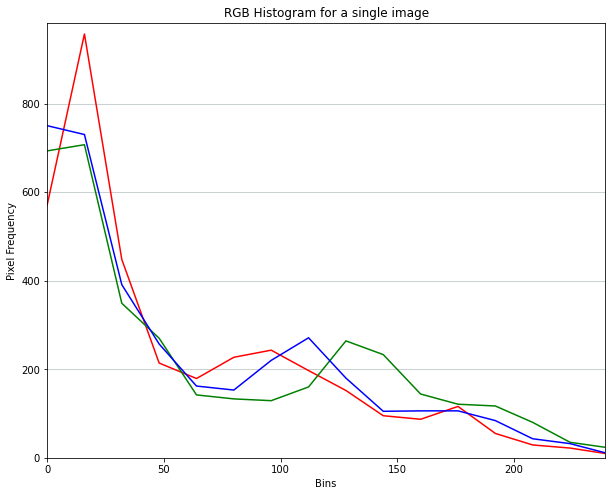

In [551]:
# Matplot lib plot (line graph).
plt.figure(figsize=(10, 8))
bin_labels = [i for i in range(0, 255, 16)]
plt.plot(bin_labels, red_channel.iloc[0].values, color="red")
plt.plot(bin_labels, green_channel.iloc[0].values, color="green")
plt.plot(bin_labels, blue_channel.iloc[0].values, color="blue")
plt.xlim((0, 255-16))
plt.ylim(0, max(max(red_channel.iloc[0].values), max(green_channel.iloc[0].values), max(blue_channel.iloc[0].values)) + 25)  # Add padding.
plt.xlabel("Bins")
plt.ylabel("Pixel Frequency")
plt.title("RGB Histogram for a single image")
plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.5)
    
# Save and display chart.
plt.savefig("rgb_hist_single_image.png")
plt.show()

Visualise the aggregate RGB histogram for all images

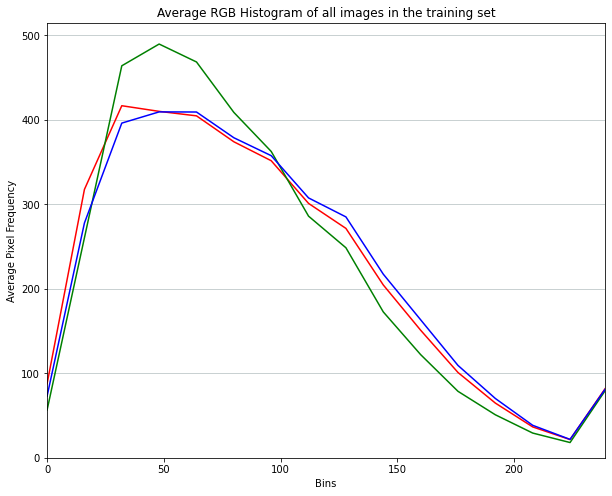

In [552]:
# Matplot lib plot (line graph).
plt.figure(figsize=(10, 8))
plt.plot(bin_labels, red_channel.mean().values, color="red")
plt.plot(bin_labels, green_channel.mean().values, color="green")
plt.plot(bin_labels, blue_channel.mean().values, color="blue")
plt.xlim((0, 255-16))
plt.ylim(0, max(max(red_channel.mean().values), max(green_channel.mean().values), max(blue_channel.mean().values)) + 25)  # Add padding.
plt.xlabel("Bins")
plt.ylabel("Average Pixel Frequency")
plt.title("Average RGB Histogram of all images in the training set")
plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.5)
    
# Save and display chart.
plt.savefig("rgb_avg_hist_all_training_set.png")
plt.show()

### D. Class ID

In [495]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49768 entries, 5149 to 12116
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       49768 non-null  object
dtypes: object(1)
memory usage: 777.6+ KB


Count the occurences (and relative % distribution) of each class in the training set.

In [498]:
total_occurences = y_train_load.shape[0]
class_distribution = {
    'seal': {
        'occurences': y_train_load[0].value_counts()["seal"],
        'distribution': round(y_train_load[0].value_counts()["seal"] / total_occurences, 5)
    },
    'background': {
        'occurences': y_train_load[0].value_counts()["background"],
        'distribution': round(y_train_load[0].value_counts()["background"] / total_occurences, 5)
    }
}
class_distribution

{'seal': {'occurences': 7778, 'distribution': 0.12503},
 'background': {'occurences': 54432, 'distribution': 0.87497}}

Plot the distribution of classes in the training set in a bar chart.

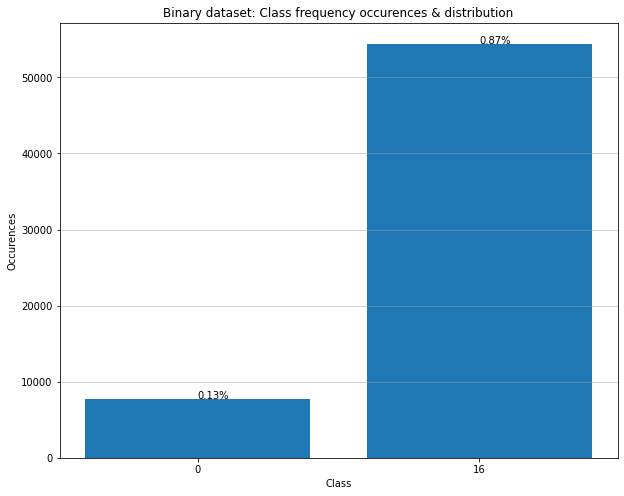

In [503]:
# Data preparation for bar chart.
data = [class_distribution['seal']['occurences'], class_distribution['background']['occurences']]
value_labels = [class_distribution['seal']['distribution'], class_distribution['background']['distribution']]
x_axis_labels = ["seal", "background"]

# Matplot lib bar chart.
plt.figure(figsize=(10, 8))
plt.xticks(range(len(data)), labels)
plt.xlabel("Class")
plt.ylabel("Occurences")
plt.title("Binary dataset: Class frequency occurences & distribution")
plt.bar(x_axis_labels, data)
plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.5)

# Add value labels for each bar.
for a,b in zip(x_axis_labels, data):
    plt.text(a, b, "{}%".format(str(round(class_distribution[a]['distribution'], 2))))
    
# Save and display chart.
plt.savefig("binary_class_distribution.png")
plt.show()

### E. Correlation

In [597]:
# temp_data = X_train_binary.concat(y_train_binary, axis=1)
temp_data = pd.concat([X_train_binary, y_train_binary], axis=1)

In [599]:
correlation_matrix = temp_data.corr()

In [603]:
correlation_matrix

,0,1,2,3,4,5,6,7,8,9,...,954,955,956,957,958,959,960,961,962,963
0,1.000000,0.388745,0.219949,0.092884,0.108756,-0.024468,0.061571,0.215500,0.380777,0.324075,...,0.097345,0.074151,0.067999,0.042945,0.022741,-0.002070,-0.029716,-0.089810,-0.235822,-0.343559
1,0.388745,1.000000,0.515055,0.260867,0.077206,-0.204973,-0.257241,-0.155534,0.065720,0.164581,...,0.097664,0.096038,0.085857,0.063156,0.031484,0.001272,-0.025729,-0.067761,-0.169202,-0.227236
2,0.219949,0.515055,1.000000,0.480091,0.221800,-0.135615,-0.272108,-0.264674,-0.110492,0.091753,...,0.113465,0.106074,0.090703,0.068948,0.034869,-0.003481,-0.036077,-0.077017,-0.169665,-0.212596
3,0.092884,0.260867,0.480091,1.000000,0.414969,0.077781,-0.148070,-0.222291,-0.163376,0.028317,...,0.102992,0.082700,0.067640,0.040231,0.008066,-0.026142,-0.049678,-0.084797,-0.172714,-0.211647
4,0.108756,0.077206,0.221800,0.414969,1.000000,0.407485,0.178999,0.024865,-0.045375,-0.029298,...,0.089163,0.062447,0.044336,0.020868,0.000932,-0.022146,-0.040774,-0.072734,-0.162387,-0.230415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,-0.002070,0.001272,-0.003481,-0.026142,-0.022146,-0.014858,0.009702,0.023156,0.018129,-0.004579,...,-0.066233,0.099485,0.285446,0.545519,0.807053,1.000000,0.805025,0.497614,0.270341,-0.002564
960,-0.029716,-0.025729,-0.036077,-0.049678,-0.040774,-0.020704,0.004571,0.012414,0.004367,-0.022646,...,-0.126384,-0.016734,0.118702,0.294063,0.524186,0.805025,1.000000,0.789823,0.466384,0.075776
961,-0.089810,-0.067761,-0.077017,-0.084797,-0.072734,-0.035115,-0.016770,-0.016361,-0.022092,-0.064513,...,-0.165392,-0.083824,0.001111,0.120936,0.276844,0.497614,0.789823,1.000000,0.724038,0.215676
962,-0.235822,-0.169202,-0.169665,-0.172714,-0.162387,-0.078546,-0.067711,-0.089883,-0.093672,-0.169418,...,-0.218051,-0.148434,-0.080083,0.013028,0.125078,0.270341,0.466384,0.724038,1.000000,0.565287


In [611]:
print("10 features with the strongest positive correlation with the  output:")
display(correlation_matrix.iloc[963].sort_values(ascending=False).head(11))
print("\n10 features with the strongest negative correlation with the  output:")
display(correlation_matrix.iloc[963].sort_values(ascending=True).head(10))

10 features with the strongest positive correlation with the  output:


963    1.000000
947    0.999536
931    0.999236
962    0.565287
930    0.564637
946    0.549370
961    0.215676
929    0.206197
945    0.189688
948    0.082540
960    0.075776
Name: 963, dtype: float64


10 features with the strongest negative correlation with the  output:


891   -0.377049
855   -0.373452
738   -0.349698
882   -0.348397
0     -0.343559
747   -0.342780
774   -0.339837
819   -0.338024
153   -0.333938
117   -0.327793
Name: 963, dtype: float64

**Observations**:
* The features that have the strongest positive correlation with the output label are between the range 929 to  963, falling into the category of RGB histogram features.
* The features that have the strongest negative correlation with the output label are between the range 0 to 891, falling into the category of HoG features.
* No normal distribution features show strong correlation.

--> Can drop the normal distribution features from the data set.

# Part 4: Prepare inputs

### Split Train/Validation data sets

The data is already split into training and testing sets. To avoid data snooping, the testing set is ignored until the evaluation section.

However, the training set is further split between a training and a validation set to evaluate its performance during training.

A randomised 80%/20% split is used rather than stratified sampling because the dataset is large enough. According to Hands-On ML, if the dataset is large enough, the risk of introducing sampling bias is low (he mentions a set of 1,000 rows, whereas ours has 62210 rows).

The random number generator's seed is set at a fixed value to ensure that it always generates the same shuffle indices when re-running the code, ensuring reproducibility.

In [504]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train_binary, 
                                                            y_train_binary, 
                                                            test_size=0.2, 
                                                            random_state=RANDOM_SEED)

Confirm new training dataset sizes:

In [505]:
print("Training set split:\nTrain set size = {}\nValidation set size = {}".format(X_train.shape, X_validate.shape))

Training set split:
Train set size = (49768, 964)
Validation set size = (12442, 964)


### Data conversion

Convert class ID output to boolean format for logistic regression (True if it's a "seal", False if it's a "background").

In [506]:
y_train_seal = (y_train == "seal")

# Parts 5/6: Select & train classification models

In [507]:
%%time
y_train_seal_unravelled = y_train_seal.values.ravel()
sgd_classifier = SGDClassifier(max_iter=1000, tol=1e-3, random_state=RANDOM_SEED)
sgd_classifier.fit(X_train, y_train_seal_unravelled)
# use values to get the values in an array, so a shape of (n,1) and then ravel() to the convert that array shape to (n, )

CPU times: user 22.6 s, sys: 249 ms, total: 22.9 s
Wall time: 23.2 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=111, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [508]:
y_prediction = sgd_classifier.predict(X_train)
confusion_matrix = confusion_matrix(y_train_seal, y_prediction)

Text(0.5, 1.0, 'Confusion matrix (normalised)')

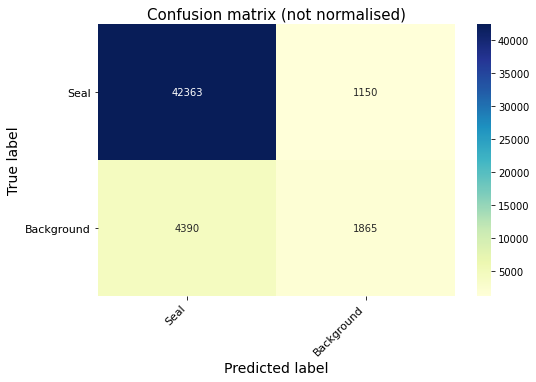

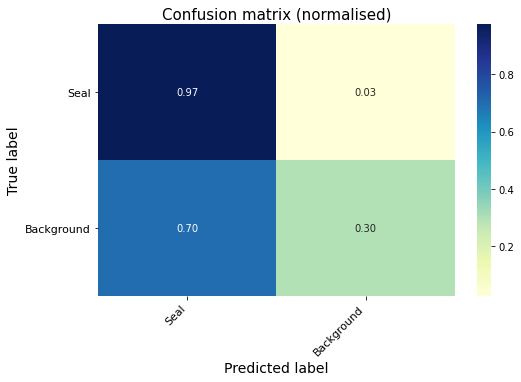

In [509]:
# Confusion matrix.
cm_df = pd.DataFrame(confusion_matrix, index=["Seal", "Background"], columns=["Seal", "Background"], )
fig = plt.figure(figsize=(8,5))
heatmap = sns.heatmap(cm_df, cmap="YlGnBu", annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=11)
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.title("Confusion matrix (not normalised)", fontsize=15)

# Normalied confusion matrix.
cm_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cm_norm, index=["Seal", "Background"], columns=["Seal", "Background"], )
fig = plt.figure(figsize=(8,5))
heatmap = sns.heatmap(cm_df, cmap="YlGnBu", annot=True, fmt=".2f")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=11)
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.title("Confusion matrix (normalised)", fontsize=15)

# Part 7: Evaluating & comparing models performance 

### Load testing data

In [510]:
X_test = pd.read_csv("../data/binary/X_test.csv")

# Part 8: Critical discussion of the results, approach and methods

In [511]:
#todo

# Helper Functions

In [512]:
def save_model(model, model_type):
    """
    Function to save the model to a file.
    :param model:
    :param model_type:
    :return:
    """
    joblib.dump(model, "trained_models/{}.pkl".format(model_type))

In [513]:
def load_model(model_type):
    """
    Function to load model.
    :param model_type:
    :return:
    """
    return joblib.load("trained_models/{}.pkl".format(model_type))